# This script is used to calculate the parameters $\alpha$ and N$_{\rm tot}$ described in Sec. 3 of the paper.

In [1]:
import numpy as np, astropy, scipy, glob, sys
import matplotlib.pyplot as pl
from scipy.optimize import curve_fit
from scipy.special import factorial
import scipy.signal as sig
import scipy.stats as st
from scipy.interpolate import interp1d
#import seaborn

import plot_conf_int
import dosurvey, populate

#%pylab
%matplotlib inline

- This script is used to produce Fig. 2 in KKL03 and fit a Poisson function to the distribution. This fitting gives us the parameter $\lambda$ from the same figure.
- $\lambda$ is calculated for multiple population sizes, same as in KKL03. 

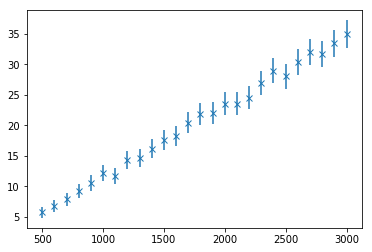

[ 5.72633159  6.71582585  7.83914648  9.26032965 10.54092673 12.14081671
 11.75083209 14.30870455 14.59610565 16.14946357 17.61498887 18.29322236
 20.42579459 21.78797614 21.93623172 23.56865123 23.55747172 24.50739247
 26.91544046 28.93387369 28.04543211 30.33986718 31.98714481 31.64546763
 33.47686075 34.94971421]
[0.91983016 0.99613709 1.07622676 1.1697219  1.24798336 1.33934774
 1.31766105 1.45401724 1.46854716 1.5447153  1.6132831  1.64404804
 1.73723623 1.79422888 1.80032292 1.86610795 1.86566531 1.90290869
 1.99420657 2.06762935 2.03563761 2.11726996 2.17398797 2.16234585
 2.22403573 2.27243365]


In [36]:
def Poisson(x, lam):
    
    return lam ** x * np.exp(-1 * lam) / factorial(x)

paths = sorted(glob.glob("./pop_result_1208_general/*npy"))

Ntot = np.arange(500, (len(paths) * 100 + 500), 100)
xaxis = np.arange(0, 200, 1)

detect = np.load(paths[0])
prob = np.full((len(detect), 200), 0.0)
mean_prob = np.full((len(paths), 200), 0.0)
std_prob = np.full((len(paths), 200), 0.0)
mean_prob_norm = np.full((len(paths), 200), 0.0)

lambdas = np.full((len(paths)), 0.0)
lambdas_err = np.full((len(paths)), 0.0)

for jj, filename in enumerate(paths):
    
    prob = np.full((len(detect), 200), 0.0)
    
    #print "On filename:{}".format(filename)
    detect = np.load(filename)
    detect = np.asarray(detect, dtype = np.int)
    
    for ii, vals in enumerate(detect):
        
        unique, counts = np.unique(vals, return_counts = True)
        
        probability = counts / np.sum(counts, dtype = np.float64)
        
        prob[ii][unique] = probability
        
    mean_prob[jj] = np.mean(prob, axis = 0)
    std_prob[jj] = np.std(prob, axis = 0)
    
    mean_prob_norm[jj] = mean_prob[jj] / np.sum(mean_prob[jj])
    
    popt, pconv = curve_fit(Poisson, xaxis, mean_prob_norm[jj], maxfev = 1000)
    '''
    if jj == 8:
        
        #pl.plot(xaxis, mean_prob[jj], color = 'r')
        pl.plot(xaxis, mean_prob_norm[jj], marker = 'o', color = 'k', label = 'Simulation')
        pl.plot(xaxis, Poisson(xaxis, *popt), marker = 's', color = 'c', label = 'Poisson')
        #pl.title(r"Results for $N_{\rm tot}$ = " + str(Ntot[jj]))
        pl.xlabel(r"N$_{\rm obs}$", fontsize = 22)
        pl.ylabel(r"P(N$_{\rm obs}$)", fontsize = 22)
        pl.legend(loc = 'best')
        pl.show()
      '''
    lambdas[jj] = popt[0]
    lambdas_err[jj] = 1.96 * np.sqrt(popt[0] / len(Ntot))

pl.errorbar(Ntot, lambdas, yerr = lambdas_err, marker = 'x', ls = '')

pl.show()
print lambdas
print lambdas_err

- The following script reads in the $\lambda$s for multiple populations, and according to the arguments in KKL03, fits a straight line to obtain $\alpha$.

- Using the above $\alpha$, we calculate N$_{\rm tot}$ (refered to as N$_{\rm pop}$ in the snippet below: $$ N_{\rm pop} = \frac{1}{\alpha} $$

$\alpha$ = [0.01157361]


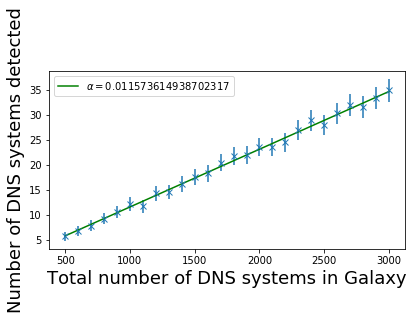

86.40342756315377


In [37]:
def line(x, a):
    
    return a * x

popt, pconv = curve_fit(line, Ntot, lambdas, sigma = lambdas_err)

print r"$\alpha$ = {}".format(popt)

pl.errorbar(Ntot, lambdas, yerr = lambdas_err, marker = 'x', ls = '')
pl.plot(Ntot, line(Ntot, *popt), color = 'g', label = r"$\alpha = $" + str(popt[0]))

#pl.xlabel(r"N$_{\rm tot}$", fontsize = 22)
#pl.ylabel(r"$\lambda$", fontsize = 22)

pl.xlabel(r"Total number of DNS systems in Galaxy", fontsize = 18)
pl.ylabel(r"Number of DNS systems detected", fontsize = 18)

pl.tight_layout()
pl.legend(loc = 'best')
pl.show()

N_pop = 1 / popt[0]

print N_pop
